In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
#read saved csv file
conComplaintDf=pd.read_csv("Consumer_Complaints.csv",converters={'ZIP code': lambda x: str(x)})

#ccDf=conComplaintDf.groupby(['Company response to consumer']).count()


In [2]:
#order the responses
#0 closed with monetary relief
#1 closed with non-monetary relief
#2 closed with relief
#3 closed with explanation
#4 closed
#5 closed without relief
#6 untimely response
#7 in progress
conComplaintDf['respCode']=np.where(conComplaintDf['Company response to consumer']== 'Closed with monetary relief',0,
    np.where(conComplaintDf['Company response to consumer']== 'Closed with non-monetary relief',1,
        np.where(conComplaintDf['Company response to consumer']== 'Closed with relief',2,
            np.where(conComplaintDf['Company response to consumer']== 'Closed with explanation',3,
                np.where(conComplaintDf['Company response to consumer']== 'Closed',4,
                    np.where(conComplaintDf['Company response to consumer']== 'Closed without relief',5,
                        np.where(conComplaintDf['Company response to consumer']== 'Untimely response',6,
                            np.where(conComplaintDf['Company response to consumer']== 'In progress',7,8))))))))

In [3]:
#clean the date received field
#convert 'date received' column from string to datetime
#align all complaints to end of month 
#create a month-year column

import calendar
import datetime

#conComplaintDfStg['Date received'].dtype
conComplaintDf['dateRec']=pd.to_datetime(conComplaintDf['Date received'])#,format='%B/%d/%y')
conComplaintDf['adjDate'] = conComplaintDf['dateRec'].map(
    lambda x: datetime.datetime(
        x.year,
        x.month,
        max(calendar.monthcalendar(x.year, x.month)[-1][:5])
    )
)
conComplaintDf['monYear']=conComplaintDf['adjDate'].apply(lambda x: x.strftime('%B-%Y'))


In [8]:
#drop rows without complete information(6&7) create data frames for data analysis

#conComplaintDfStg=
conComplaintDf.drop(conComplaintDf[conComplaintDf.respCode >=6].index, inplace=True)
conComplaintDf['zip3']=conComplaintDf['ZIP code'].str[:3]


#create dataframe with complaints resulting in monetary relief
#response0Df=conComplaintDf.loc[(conComplaintDf.respCode== 0)]
                               

In [9]:
#download urban area to cbsa file
#UA:urban area number
#UANAME: urban area name
#CBSA: corebased statistical area number(micro/metropolitan statistical area)
#MNAME: cbsa name
#MEMI: 1=metropolitan statistical area; 2=micropolitan statistical area
url="https://www2.census.gov/geo/docs/maps-data/data/rel/ua_cbsa_rel_10.txt"
uaToCbsaDf=pd.read_csv(url,encoding='latin1')#converters={'ZCTA5': lambda x: str(x)})
uaToCbsaDf=uaToCbsaDf[['UA','UANAME','CBSA','MNAME','MEMI','POPPT']]
uaToCbsaDf.drop(uaToCbsaDf[(uaToCbsaDf.MEMI != 1) | (uaToCbsaDf.UA== 99999)|(uaToCbsaDf.CBSA==99999) ].index, inplace=True)



In [10]:
#download zip to cbsa file

import urllib.request
import requests
import io
url="https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_cbsa_rel_10.txt"
#zipToSaDf=pd.read_csv(url,'ZCTA5',index_col=0)
#preserve leading zeros in zip5
zipToSaDf=pd.read_csv(url,converters={'ZCTA5': lambda x: str(x)})
zipToSaDf=zipToSaDf[['ZCTA5','CBSA','ZPOP','MEMI']]
zipToSaDf.drop(zipToSaDf[(zipToSaDf.MEMI)!=1].index,inplace=True)
zipToSaDf['zip3']=zipToSaDf.ZCTA5.str[:3]


In [11]:
#some records contain zip5 and some contain zip3.  This causes problems when merging
#I will split the cfpb data into two files
#1- with full 5-digit zip code
#2- with 3-digit zip code
conComplaintZ5=conComplaintDf[conComplaintDf['ZIP code'].str.contains("XX")==False]

conComplaintZ3=conComplaintDf[conComplaintDf['ZIP code'].str.contains("XX")==True]


In [12]:
#later we will use zip codes to merge with census files(urban area and msa)
#since zip3 is truncated zip5, they may link with multiple zip5s and UA/MSA
#I want to remove the smaller(by population) instances of zip3
#sort by zip3 and zip-level population
#goal is to keep zip3 with largest population 
zipToSaDf.sort_values(['zip3','ZPOP'])
zipToSaDfZ3=zipToSaDf.drop_duplicates(['zip3'],keep='last')


In [13]:
#merge the zip To CBSA file onto the split(by zip3 and zip5) consumer complaint data
cfpbComplaintCbsaZ5= pd.merge(conComplaintZ5,zipToSaDf,left_on=['ZIP code','zip3'],right_on=['ZCTA5','zip3'],how='left')
cfpbComplaintCbsaZ3= pd.merge(conComplaintZ3,zipToSaDfZ3,on=['zip3'],how='left')


In [14]:
#concatenate the zip5 and zip3 files
cfpbComplaintCbsa= pd.concat([cfpbComplaintCbsaZ5,cfpbComplaintCbsaZ3])



In [15]:

#UA to CBSA is a 'one to many' relationship. keep CBSA with largest population for this exercise
uaToCbsaDf.sort_values(['CBSA','POPPT'],inplace=True)
uaToCbsaDf=uaToCbsaDf.drop_duplicates(['CBSA'],keep='last')



In [16]:
#change the dtype from float to int
cfpbComplaintCbsa['CBSA']=cfpbComplaintCbsa['CBSA'].fillna(0.0).astype(int)


In [17]:
#now merge with the uaCbsa data to add urban area information
cfpbComplaintCbsaUa=pd.merge(cfpbComplaintCbsa,uaToCbsaDf, on='CBSA', how = 'inner')


In [18]:
from zipfile import ZipFile
from urllib.request import urlopen   
import pandas as pd
import os

URL = \
    'http://www2.census.gov/geo/docs/maps-data/data/gazetteer/Gaz_ua.zip'

# open and save the zip file onto computer
url = urlopen(URL)
output = open('zipFile.zip', 'wb')    # note the flag:  "wb"        
output.write(url.read())
output.close()

# read the zip file as a pandas dataframe
uaGaz = pd.read_csv('zipFile.zip',sep='\t',encoding='latin1')   # pandas version 0.18.1 takes zip files       

# if keeping on disk the zip file is not wanted, then:
#os.remove(zipName)   # remove the copy of the zipfile on disk

In [19]:
#keep ID, Lat, Long fields and merge onto cfpb data
#uaGaz.count()
#uaGaz=uaGaz[['GEOID','INTPTLAT','INTPTLONG']]
gazCols=['GEOID','NAME',
 'UATYPE',
 'POP10',
 'HU10',
 'ALAND',
 'AWATER',
 'ALAND_SQMI',
 'AWATER_SQMI',
 'INTPTLAT',
 'INTPTLONG']
uaGaz.columns=gazCols
cfpbComplaintCbsaUaLl= pd.merge(cfpbComplaintCbsaUa,uaGaz,left_on='UA',right_on='GEOID',how='left')


In [20]:
cfpbComplaintCbsaUaLl.iloc[:,-1]
cfpbComplaintCbsaUaLl.rename(columns={'INTPTLONG\n':'INTPTLONG'}, inplace=True)

In [40]:
#just for mapping 
map_data=cfpbComplaintCbsaUaLl[['UA','INTPTLAT','INTPTLONG']].groupby(['UA','INTPTLONG','INTPTLAT']).size().reset_index(name='counts')

/home/augustine/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/augustine/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/augustine/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


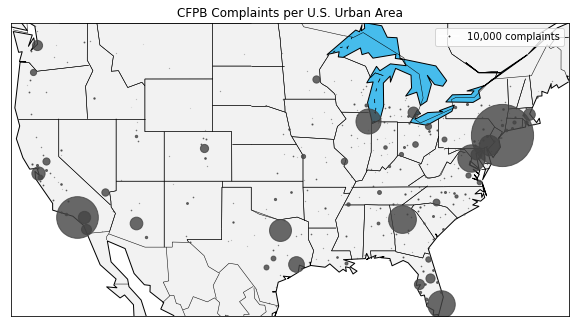

In [303]:
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(10,20))

m= Basemap(resolution='c', # c, l, i, h, f or None
            projection='merc',
            lat_0=-90, lon_0=49,
            llcrnrlon=-125., llcrnrlat= 25, urcrnrlon=-67, urcrnrlat=49)

m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
plt.title('CFPB Complaints per U.S. Urban Area')

#gt = mpatches.Circle((1,1),1,color='#444444',label='10,000 complaints')
#plt.legend(handles=[gt], loc=3)
#plt.legend(['ro'],['1,000 complaints'])
#plt.legend([red_dot, (red_dot, white_cross)], ["Attr A", "Attr A+B"])



line1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="#444444", markersize=3)

plt.legend([line1],['10,000 complaints'],numpoints=1, loc=1)

def plot_area(line):
    count = line.counts#loc[new_areas.pos == pos]['count']
#x,y= m(line.INTPTLONG,line.INTPTLAT)
    lon= line.iloc[0]['INTPTLONG']#[0::1] #-114.568173 #line.INTPTLONG
    lat= line.iloc[0]['INTPTLAT']#32.676904#ine.INTPTLAT
    x,y= m(lon,lat)
    size = (count/1000)#+1 #** 2 + 3
    m.plot(x, y, 'o', markersize= size, color='#444444', alpha=0.8)


#size
    
#map_data[['INTPTLONG','INTPTLAT','counts']].apply(plot_area)
numRows= map_data['counts'].size

#map_data.apply(plot_area)
for i in range(1,numRows):
    plot_area(map_data[i-1:i])
    

In [23]:
cfpbComplaintCbsaUaLl['target']=np.where(cfpbComplaintCbsaUaLl['respCode']== 0,1,0)

In [ ]:
#transform categorical variables into 1/0's
#catCols= ['State','Product','Issue','UA']
#cfpbWDummies=pd.get_dummies( cfpbComplaintCbsaUaLl,columns=catCols)

In [24]:
#Text processing replace na with an empty string
cfpbComplaintCbsaUaLl['Consumer complaint narrative']= cfpbComplaintCbsaUaLl['Consumer complaint narrative'].fillna('')
cfpbComplaintCbsaUaLl['State']= cfpbComplaintCbsaUaLl['State'].fillna('')
#transform categorical variables into binary
cfpbComplaintCbsaUaLl['UA']=cfpbComplaintCbsaUaLl['UA'].astype('category')
#catCols= ['State','Product','Issue','UA']
catCols= ['Product','Issue','UA']
dfDummies= pd.get_dummies(cfpbComplaintCbsaUaLl[catCols])
dataStg= pd.concat([cfpbComplaintCbsaUaLl,dfDummies],axis=1)


In [25]:
#define function to process raw text one record at a time
from bs4 import BeautifulSoup
import re 
from nltk.stem import PorterStemmer 
ps= PorterStemmer()
from nltk.corpus import stopwords 

def processText(raw):
#remove tags
    text = BeautifulSoup(raw,'lxml')
#remove numbers so we only have text    
    letters= re.sub("[^a-zA-Z]"," ",text.get_text())
#change everything to lower case and split 
    lowerCase= letters.lower()
#stem lower case letters
    stems= ps.stem(lowerCase).split()
#remove common words using nltk dictionary
    stopWords= set(stopwords.words('english'))
    procdText= [j for j in stems if not j in stopWords]
#mash everything back together     
    return( " ".join(procdText))

In [26]:
#train/test splitting
from sklearn.model_selection import train_test_split 

#split dataStg into train/ test
train, test= train_test_split(dataStg,test_size=.2)

# recreate index in test and train sets so we can run through the text processing function
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


In [168]:
THIS IS FOR TESTING
#create probabilities of monetary compensation for some variables
#will also impute means (based on column value) for NaN at the same time
from sklearn.preprocessing import Imputer
imp= Imputer(missing_values='NaN', strategy='mean',axis=0)

#first create data frame with monetary compansation
response0Df= train.loc[(train.respCode== 0)]

#producct
prodAll= train.Product.value_counts()
prod0=response0Df.Product.value_counts()
productRate= prod0/prodAll
productRate.rename('prdRate',inplace=True)
productRateDfTemp= productRate.to_frame()
productRateDf= pd.DataFrame(imp.fit_transform(productRateDfTemp))
productRateDf.columns= productRateDfTemp.columns
productRateDf.index= productRateDfTemp.index
train=pd.merge(train,productRateDf,left_on='Product',right_index=True,how='left')
#now do add the same rates to the test data set
test=pd.merge(test,productRateDf,left_on='Product',right_index=True,how='left')
test['prdRate']=imp.transform(test[['prdRate']]).ravel()



In [27]:
#create probabilities of monetary compensation for some variables
#will also impute means (based on column value) for NaN at the same time
from sklearn.preprocessing import Imputer
imp= Imputer(missing_values='NaN', strategy='mean',axis=0)

#first create data frame with monetary compansation
response0Df= train.loc[(train.respCode== 0)]
#state
#add the following state 
#stAdd= pd.Series([np.NaN],index=['AE'])
#stateAll= train.State.value_counts()
#state0=response0Df.State.value_counts()
#stateRate= state0/stateAll
#stateRate.rename('stRate',inplace=True)
#stateRateDfTemp=stateRate.to_frame()
#stateRateDf=pd.DataFrame(imp.fit_transform(stateRateDfTemp))
#stateRateDf.columns= stateRateDfTemp.columns
#stateRateDf.index= stateRateDfTemp.index
#train=pd.merge(train,stateRateDf,left_on='State',right_index=True,how='left')
#now do add the same rates to the test data set
#test=pd.merge(test,stateRateDf,left_on='State',right_index=True,how='left')
#test['stRate']=imp.transform(test[['stRate']]).ravel()

#producct
prodAll= train.Product.value_counts()
prod0=response0Df.Product.value_counts()
productRate= prod0/prodAll
productRate.rename('prdRate',inplace=True)
productRateDfTemp= productRate.to_frame()
productRateDf= pd.DataFrame(imp.fit_transform(productRateDfTemp))
productRateDf.columns= productRateDfTemp.columns
productRateDf.index= productRateDfTemp.index
train=pd.merge(train,productRateDf,left_on='Product',right_index=True,how='left')
#now do add the same rates to the test data set
test=pd.merge(test,productRateDf,left_on='Product',right_index=True,how='left')
test['prdRate']=imp.transform(test[['prdRate']]).ravel()


#issue
issAll= train.Issue.value_counts()
iss0=response0Df.Issue.value_counts()
issueRate=iss0/issAll
issueRate.rename('issRate',inplace=True)
issueRateDfTemp= issueRate.to_frame()
issueRateDf=pd.DataFrame(imp.fit_transform(issueRateDfTemp))
issueRateDf.columns= issueRateDfTemp.columns
issueRateDf.index= issueRateDfTemp.index
train=pd.merge(train,issueRateDf,left_on='Issue',right_index=True,how='left')
#now do add the same rates to the test data set
test=pd.merge(test,issueRateDf,left_on='Issue',right_index=True,how='left')
test['issRate']=imp.transform(test[['issRate']]).ravel()

#Urban Area
uaAll= train.UA.value_counts()
ua0= response0Df.UA.value_counts()
uaRate= ua0/uaAll
uaRate.rename('uaRate',inplace=True)
uaRateDfTemp= uaRate.to_frame()
uaRateDf=pd.DataFrame(imp.fit_transform(uaRateDfTemp))
uaRateDf.columns= uaRateDfTemp.columns
uaRateDf.index= uaRateDfTemp.index
train=pd.merge(train,uaRateDf,left_on='UA',right_index=True,how='left')
#now do add the same rates to the test data set
test=pd.merge(test,uaRateDf,left_on='UA',right_index=True,how='left')
test['uaRate']=imp.transform(test[['uaRate']]).ravel()


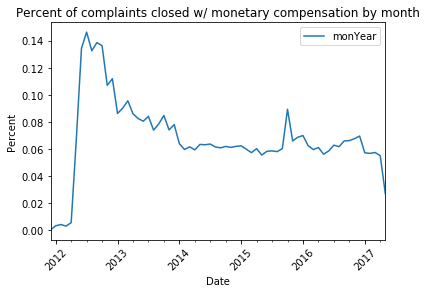

In [28]:

reliefDf= cfpbComplaintCbsaUaLl.loc[(cfpbComplaintCbsaUaLl.respCode== 0)]
monYearAll=cfpbComplaintCbsaUaLl.monYear.value_counts()
monYear0=reliefDf.monYear.value_counts()
monYearPct=monYear0/monYearAll
monYearPctDf= monYearPct.to_frame()
#monYearPctDf=
monYearPctDf.reset_index(inplace=True)
monYearPctDf['index']=pd.to_datetime(monYearPctDf['index'])
monYearPctDf.sort_values('index',inplace=True)
monYearPctDf.set_index('index',inplace=True)
#resp0MonYearPct
#monYearPctDf
monYearPctDf.plot(kind='line',title='Percent of complaints closed w/ monetary compensation by month')
plt.xticks(rotation=45)
#fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Percent')
plt.show()



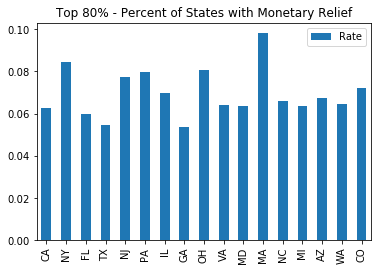

In [29]:


stAll= cfpbComplaintCbsaUaLl.State.value_counts()
stRelief=reliefDf.State.value_counts()

stReliefDf=stRelief.to_frame()
stReliefDf.sort_values('State',ascending='False')
stateRatesAll=stRelief/stAll
stateRatesAll.rename('Rate',inplace=True)
stateRatesAllDf=stateRatesAll.to_frame()

stReliefDf['cum_sum'] = stReliefDf.State.cumsum()
stReliefDf['cum_perc'] = 100*stReliefDf.cum_sum/stReliefDf.State.sum()
stReliefDf=stReliefDf[stReliefDf.cum_perc<= 80]
#issCounts=issReliefDf.Issue.value_counts()
#issCounts
#issRates=issCounts/issRelief
#issRatesDf= issRates.to_frame()

stRelief80Df= pd.merge(stReliefDf,stateRatesAllDf,left_index=True,right_index=True,how='left')

stplt=stRelief80Df[['Rate']].plot(kind='bar',title='Top 80% - Percent of States with Monetary Relief')


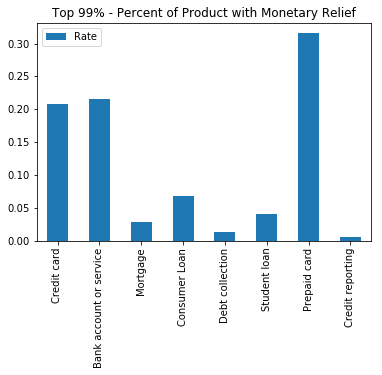

In [30]:

prodAll= cfpbComplaintCbsaUaLl.Product.value_counts()
prodRelief=reliefDf.Product.value_counts()

prodReliefDf=prodRelief.to_frame()
prodReliefDf.sort_values('Product',ascending='False')
productRatesAll=prodRelief/prodAll
productRatesAll.rename('Rate',inplace=True)
productRatesAllDf=productRatesAll.to_frame()

prodReliefDf['cum_sum'] = prodReliefDf.Product.cumsum()
prodReliefDf['cum_perc'] = 100*prodReliefDf.cum_sum/prodReliefDf.Product.sum()
prodReliefDf=prodReliefDf[prodReliefDf.cum_perc<= 99]
#issCounts=issReliefDf.Issue.value_counts()
#issCounts
#issRates=issCounts/issRelief
#issRatesDf= issRates.to_frame()

prodRelief80Df= pd.merge(prodReliefDf,productRatesAllDf,left_index=True,right_index=True,how='left')

prodplt=prodRelief80Df[['Rate']].plot(kind='bar',title='Top 99% - Percent of Product with Monetary Relief')


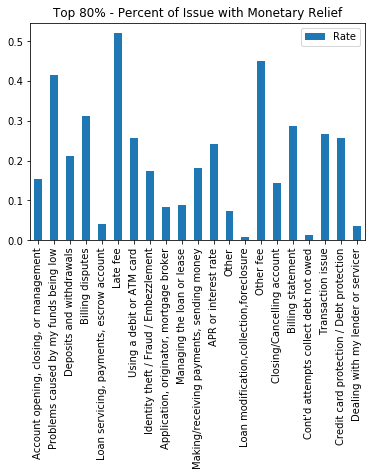

In [31]:

#prodNames= cfpbComplaintCbsaUaLl.Product.unique()


#issueNames= cfpbComplaintCbsaUaLl.Issue.unique()
issAll= cfpbComplaintCbsaUaLl.Issue.value_counts()
issRelief=reliefDf.Issue.value_counts()

issReliefDf=issRelief.to_frame()
issReliefDf.sort_values('Issue',ascending='False')
issueRatesAll=issRelief/issAll
issueRatesAll.rename('Rate',inplace=True)
issueRatesAllDf=issueRatesAll.to_frame()

issReliefDf['cum_sum'] = issReliefDf.Issue.cumsum()
issReliefDf['cum_perc'] = 100*issReliefDf.cum_sum/issReliefDf.Issue.sum()
issReliefDf=issReliefDf[issReliefDf.cum_perc<= 80]
#issCounts=issReliefDf.Issue.value_counts()
#issCounts
#issRates=issCounts/issRelief
#issRatesDf= issRates.to_frame()

issRelief80Df= pd.merge(issReliefDf,issueRatesAllDf,left_index=True,right_index=True,how='left')

issplt=issRelief80Df[['Rate']].plot(kind='bar',title='Top 80% - Percent of Issue with Monetary Relief')
#plt.bar()
#issueRatesAllDf
#uaNames= cfpbComplaintCbsaUaLl.UA.unique()

In [143]:
Don't use anymore
#add the same rates to the test data set
test=pd.merge(test,stateRateDf,left_on='State',right_index=True,how='left')
test=pd.merge(test,productRateDf,left_on='Product',right_index=True,how='left')
test=pd.merge(test,issueRateDf,left_on='Issue',right_index=True,how='left')
test=pd.merge(test,uaRateDf,left_on='UA',right_index=True,how='left')

In [32]:
#loop through train data and process text
#get number of rows
numRows= train["Consumer complaint narrative"].size
print(numRows)
#init empty list
cleanText= []
#now loop through text rows
for i in range(0,numRows):
    if ((i+1)%50000 == 0 ):
        print ("processing %d of %d\n" %(i+1,numRows))
    cleanText.append(processText(train["Consumer complaint narrative"][i]))
    


575894
processing 50000 of 575894

processing 100000 of 575894

processing 150000 of 575894

processing 200000 of 575894

processing 250000 of 575894

processing 300000 of 575894

processing 350000 of 575894

processing 400000 of 575894

processing 450000 of 575894

processing 500000 of 575894

processing 550000 of 575894



In [33]:
#Do the same processing loop through text for the test data
numRows= test["Consumer complaint narrative"].size
print(numRows)
#init empty list
testText= []
#now loop through text rows
for i in range(0,numRows):
    if ((i+1)%50000 == 0 ):
        print ("processing %d of %d\n" %(i+1,numRows))
    testText.append(processText(test["Consumer complaint narrative"][i]))
    


143974
processing 50000 of 143974

processing 100000 of 143974



In [34]:
#create arrays that just contain the target variables
#these arrays are used in chi2 test
yTrain, yTest = train.target, test.target

In [35]:
#drop fields that will not be used as features

trainFt=train.drop(['Product','State','Issue','UA','Date received','Sub-product','Sub-issue','Consumer complaint narrative','Company public response',
 'Company','ZIP code','Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer',
 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'respCode', 'dateRec', 'adjDate', 'monYear', 'zip3',
 'ZCTA5', 'CBSA', 'ZPOP', 'MEMI_x', 'UANAME', 'MNAME', 'MEMI_y', 'POPPT', 'GEOID', 'NAME', 'UATYPE', 'POP10',
 'HU10', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG', 'target'],axis=1)
#trainFtAr=sp.sparse.csr_matrix(trainFt)

testFt= test.drop(['Product','State','Issue','UA','Date received','Sub-product','Sub-issue','Consumer complaint narrative','Company public response',
 'Company','ZIP code','Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer',
 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'respCode', 'dateRec', 'adjDate', 'monYear', 'zip3',
 'ZCTA5', 'CBSA', 'ZPOP', 'MEMI_x', 'UANAME', 'MNAME', 'MEMI_y', 'POPPT', 'GEOID', 'NAME', 'UATYPE', 'POP10',
 'HU10', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG', 'target'],axis=1)
#testFtAr= sp.sparse.csr_matrix(testFt)

In [89]:
print(featureNames)
len(featureNames)

['aa', 'aaa', 'aaaa', 'aaaaan', 'aaaaargh', 'aaaallllll', 'aaadvantage', 'aaaked', 'aaarm', 'aab', 'aac', 'aacceptance', 'aaccount', 'aaccounts', 'aacount', 'aact', 'aadavantage', 'aaddress', 'aadvantage', 'aadvatage', 'aafes', 'aafraid', 'aag', 'aagain', 'aagainst', 'aaii', 'aaked', 'aaliant', 'aallc', 'aallcdelete', 'aalthough', 'aamco', 'aamerican', 'aams', 'aand', 'aapplication', 'aapproved', 'aapproximatly', 'aaproximately', 'aaprtment', 'aarea', 'aargon', 'aarmr', 'aarons', 'aarp', 'aarrearge', 'aartment', 'aas', 'aasigned', 'aasked', 'aasking', 'aastra', 'aat', 'aatached', 'aattempting', 'aaudulent', 'aavantage', 'ab', 'aba', 'aback', 'abad', 'abalance', 'abale', 'aballished', 'abanding', 'abandment', 'abandoment', 'abandon', 'abandonded', 'abandoned', 'abandoning', 'abandonment', 'abandons', 'abank', 'abankruptcy', 'abate', 'abated', 'abatement', 'abatements', 'abating', 'abberation', 'abbott', 'abbout', 'abbreviate', 'abbreviated', 'abbreviation', 'abbreviations', 'abc', 'abd'

63247

In [36]:
#Create count vector and normalize
#TF*IDF transformation in one step
from sklearn.feature_extraction.text import TfidfVectorizer

transformer= TfidfVectorizer(ngram_range=(1,3))

tfidf= transformer.fit_transform(cleanText)#x_train_counts)
tfidf.shape

#now extract same features from test set
x_test = transformer.transform(testText)

#save feature names
featureNames= transformer.get_feature_names()

In [37]:
#Chi-Squared selection on text features before stacking and scaling
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

ch2= SelectKBest(chi2,k=1000)

x_train = ch2.fit_transform(tfidf, yTrain)
x_train.shape


x_test_new = ch2.transform(x_test)

if featureNames:
    #update with selected feature names
    featureNames= np.asarray(transformer.get_feature_names())[ch2.get_support()]

    #featureNames = [featureNames[i] for i in ch2.get_support(indices=False)]
print(x_train.shape)
len(featureNames)

(575894, 1000)


1000

In [38]:
#concatenate features with nlp matrix
#stack after chi-squared selection
import scipy as sp
from scipy.sparse import hstack
#BELOW IS FOR STACKING AFTER CHI-SQUARE SELECTION
tfidfFt= sp.sparse.hstack((x_train,trainFt.values),format='csr')
x_testFt= sp.sparse.hstack((x_test_new,testFt.values),format='csr')
#BELOW IS FOR STACKING BEFORE CHI-SQUARE SELECTION
#tfidfFt= sp.sparse.hstack((tfidf,trainFt.values),format='csr')
#x_testFt= sp.sparse.hstack((x_test,testFt.values),format='csr')

In [39]:
#trainFt.columns
trainFt.shape
#list.train

(575894, 541)

In [40]:
#scale features to prepare for classifier

from sklearn import preprocessing

tfidfFtScaled= preprocessing.scale(tfidfFt, with_mean=False)
testFtScaled= preprocessing.scale(x_testFt, with_mean=False)
#foo=preprocessing.scale(testFt, with_mean=False)

In [41]:
#create new data frame for ML algorithms
x_train= tfidfFtScaled
x_test_new= testFtScaled

In [67]:
KEEP BUT DON'T USE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

ch2= SelectKBest(chi2,k=4000)

x_train = ch2.fit_transform(tfidfFtScaled, yTrain)
x_train.shape


x_test_new = ch2.transform(testFtScaled)

if featureNames:
    #update with selected feature names
    featureNames= np.asarray(transformer.get_feature_names())[ch2.get_support()]

    #featureNames = [featureNames[i] for i in ch2.get_support(indices=False)]
print(x_train.shape)

/home/augustine/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 63247 but corresponding boolean dimension is 63788


IndexError: index 63247 is out of bounds for axis 1 with size 63247

In [63]:
len(featureNames)
#print(featureNames)


63788

In [34]:
NOT SCALED
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

ch2= SelectKBest(chi2,k=4000)

x_train = ch2.fit_transform(tfidfFt, yTrain)
x_train.shape


x_test_new = ch2.transform(x_testFt)
#if featureNames:
    #update with selected feature names
#featureNames = [featureNames[i] for i in ch2.get_support(indices=True)]
print(x_train.shape)

(575894, 4000)


In [42]:

#import libraries
from time import time
from sklearn import svm 
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

#define function to run through different classifiers


def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf_type)
    if clf_type=='SVM':
        cv= StratifiedKFold(n_splits= 2)
    else:
        cv= StratifiedKFold(n_splits= 5)
    t0 = time()
    if clf_type=='SVM':
        clf.fit(x_train,yTrain)
        #print("roc_auc score: ", str(scores))
    else:
        scores= cross_val_score(clf, x_train, yTrain,cv= cv, scoring='roc_auc')
        clf.fit(x_train, yTrain)
        print("stratified 5-fold cross validation roc_auc score: ", str(scores))
    
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    #pred= cross_val_predict(clf, x_train, yTrain,cv=cv)
    pred = clf.predict(x_test_new)
    if clf_type== 'SVM':
        preds= clf.decision_function(x_test_new)
    else:
        preds = clf.predict_proba(x_test_new)[:,1]
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(yTest, pred)
    print("accuracy:   %0.3f" % score)
    
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if featureNames is not None and clf_type is not 'SVM':
            print("top keywords:")
            top10 = np.argsort(clf.coef_[0])[-10:]
            coefs_with_fns = sorted(zip(clf.coef_[0], featureNames))
            top = zip(coefs_with_fns[:19], coefs_with_fns[:-(10 + 1):-1])
            for (coef_1, fn_1), (coef_2, fn_2) in top:
                print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
            #print("%s: %s" % (" ".join(featureNames[top10])))
                print()
        
        #def show_most_informative_features(vectorizer, clf, n=20):
            #feature_names = vectorizer.get_feature_names()
            #coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
            #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
            #for (coef_1, fn_1), (coef_2, fn_2) in top:
                #print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
        print("classification report:")
        print(metrics.classification_report(yTest, pred))#,target_names=target_names))
        print("confusion matrix:")
        print(metrics.confusion_matrix(yTest, pred))

        
        # Compute ROC curve and ROC area for each class
        #fpr = dict()
        #tpr = dict()
        #roc_auc = dict()
        fpr, tpr, _ = metrics.roc_curve(yTest, preds)
        roc_auc = auc(fpr, tpr)

        # Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(yTest.ravel(), preds.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time




In [172]:
NOT USED
#import libraries
from time import time
from sklearn import svm 
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

#define function to run through different classifiers


def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf_type)
    cv= StratifiedKFold(n_splits= 5)
    t0 = time()
    scores= cross_val_score(clf, x_train, yTrain,cv= cv, scoring='roc_auc')
    clf.fit(x_train, yTrain)
    print("stratified 5-fold cross validation roc_auc score: ", str(scores))
    
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    #pred= cross_val_predict(clf, x_train, yTrain,cv=cv)
    pred = clf.predict(x_test_new)
    if clf_type== 'SVM':
        preds= clf.decision_function(x_test_new)
    else:
        preds = clf.predict_proba(x_test_new)[:,1]
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(yTest, pred)
    print("accuracy:   %0.3f" % score)
    
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if featureNames is not None:
            print("top keywords:")
            top10 = np.argsort(clf.coef_[0])[-10:]
            coefs_with_fns = sorted(zip(clf.coef_[0], featureNames))
            top = zip(coefs_with_fns[:19], coefs_with_fns[:-(10 + 1):-1])
            for (coef_1, fn_1), (coef_2, fn_2) in top:
                print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
            #print("%s: %s" % (" ".join(featureNames[top10])))
                print()
        
        #def show_most_informative_features(vectorizer, clf, n=20):
            #feature_names = vectorizer.get_feature_names()
            #coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
            #top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
            #for (coef_1, fn_1), (coef_2, fn_2) in top:
                #print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
        print("classification report:")
        print(metrics.classification_report(yTest, pred))#,target_names=target_names))
        print("confusion matrix:")
        print(metrics.confusion_matrix(yTest, pred))

        
        # Compute ROC curve and ROC area for each class
        #fpr = dict()
        #tpr = dict()
        #roc_auc = dict()
        fpr, tpr, _ = metrics.roc_curve(yTest, preds)
        roc_auc = auc(fpr, tpr)

        # Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(yTest.ravel(), preds.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time




In [147]:
NOT USED


#import libraries
from time import time
from sklearn import svm 
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc


#define function to run through different classifiers


def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    cv= StratifiedKFold(n_splits= 5)
    t0 = time()
    scores= cross_val_score(clf, x_train, yTrain,cv= cv, scoring='roc_auc')
    clf.fit(x_train, yTrain)
    print("stratified 5-fold cross validation roc_auc score: ", str(scores))
    
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    #pred= cross_val_predict(clf, x_train, yTrain,cv=cv)
    pred = clf.predict(x_test_new)
    if type== 'SVM':
        preds= clf.decision_function(x_test_new)
    else:
        preds = clf.predict_proba(x_test_new)[:,1]
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(yTest, pred)
    print("accuracy:   %0.3f" % score)
    
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        #if featureNames is not None:
            #print("top 10 keywords:")
            #top10 = np.argsort(clf.coef_[i])[-10:]
            #print(trim("%s: %s" % (label, " ".join(featureNames[top10]))))
        #print()
        
        
        print("classification report:")
        print(metrics.classification_report(yTest, pred))#,target_names=target_names))
        print("confusion matrix:")
        print(metrics.confusion_matrix(yTest, pred))

        
        # Compute ROC curve and ROC area for each class
        #fpr = dict()
        #tpr = dict()
        #roc_auc = dict()
        fpr, tpr, _ = metrics.roc_curve(yTest, preds)
        roc_auc = auc(fpr, tpr)

        # Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(yTest.ravel(), preds.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time




SyntaxError: invalid syntax (<ipython-input-147-10708653aaba>, line 1)

In [38]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

logReg= LogisticRegression(penalty='l1',class_weight='balanced')
#penalty='l1',class_weight='balanced')
parameters= {'C':[.01,.1,1,10]}
#fit_params= {'C':[.1,1]}
clf= GridSearchCV(logReg,fit_params,cv=2)
score= clf.fit(x_train,yTrain)
print('Best C Parametr: ', clf.best_params_)

print (roc_auc_score(clf.predict(x_test_new),yTest))

Best C Parametr:  {'C': 0.1}
0.587891992009


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.84265071  0.84092102  0.84039206  0.84128255  0.84411377]
train time: 1526.598s
test time:  0.211s
accuracy:   0.772
dimensionality: 6541
density: 0.926005
top keywords:
	-0.5906	verify accounts		0.4086	account xx     

	-0.5265	nationstar     		0.2983	home depot     

	-0.5250	used verify    		0.2642	baggage fees   

	-0.4795	possible thank 		0.2502	tcf bank reordered

	-0.4164	account xx xx  		0.2301	victim identity

	-0.3909	portfolio recovery		0.2195	account wells fargo

	-0.3847	delete information		0.2100	xx xx xxxx     

	-0.3242	depot          		0.1875	macy charged   

	-0.2445	equifax xxxx   		0.1614	boa charged xxxx

	-0.2429	inquires       		0.1412	american express fraud

classification report:
             precision    recall  f1-score   support

          0       0.98      0.77      0.86    134385
          1       

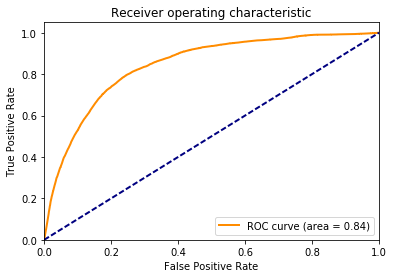

In [40]:
#tri-gram 5k features
#load results in empty array
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=1, penalty='l1',class_weight='balanced')))

LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.8468526   0.84568601  0.8451153   0.84566389  0.84769809]
train time: 2093.989s
test time:  0.195s
accuracy:   0.773
dimensionality: 6541
density: 0.889008
top keywords:
	-0.4741	nationstar     		0.2432	account xx     

	-0.2500	account xx xx  		0.2115	victim identity

	-0.2043	inquires       		0.1733	home depot     

	-0.2035	possible thank 		0.1292	baggage fees   

	-0.1940	portfolio recovery		0.1196	experian       

	-0.1788	depot          		0.1120	tcf bank reordered

	-0.1744	equifax xxxx   		0.0996	called macy told

	-0.1601	never lived    		0.0978	wells          

	-0.1480	ocwen          		0.0923	bank america charged

	-0.1469	victim identity theft		0.0902	credit reporting

classification report:
             precision    recall  f1-score   support

          0       0.98      0.77      0.86    134385
          1       0.

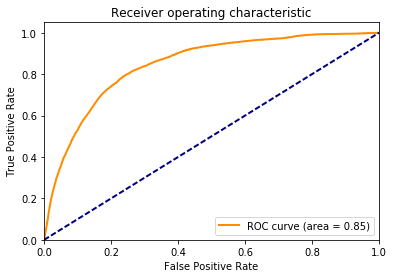

In [39]:
#tri-gram 5k features
#load results in empty array
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.1, penalty='l1',class_weight='balanced')))

LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.86171923  0.86053907  0.86018181  0.86021118  0.86046167]
train time: 1000.707s
test time:  0.136s
accuracy:   0.772
dimensionality: 6541
density: 0.739336
top keywords:
	-0.2845	nationstar     		0.1090	experian       

	-0.1296	ocwen          		0.0757	victim identity

	-0.1015	reporting      		0.0699	transunion     

	-0.0844	credit         		0.0647	home depot     

	-0.0838	remove         		0.0524	credit reporting

	-0.0789	sls            		0.0484	fair debt collection

	-0.0779	card           		0.0403	late fees      

	-0.0757	credit report  		0.0399	xxxx credit card

	-0.0754	inquires       		0.0393	america        

	-0.0735	medical        		0.0393	core advisory  

classification report:
             precision    recall  f1-score   support

          0       0.98      0.77      0.86    134385
          1       0.20      0.79

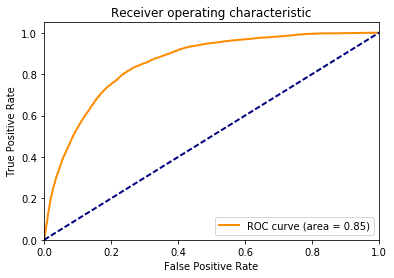

In [41]:
#tri-gram 5k features
#load results in empty array
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.01, penalty='l1',class_weight='balanced')))

In [ ]:
#tri-gram 5k features
#load results in empty array
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.001, penalty='l1',class_weight='balanced')))

In [55]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

logReg= LogisticRegression(penalty='l1',class_weight='balanced')
#penalty='l1',class_weight='balanced')
#parameters= {'C':[.01,.1,1,10]}
fit_params= {'C':[.1,1]}
clf= GridSearchCV(logReg,fit_params,cv=3)
score= clf.fit(x_train,yTrain)
print('Best C Parametr: ', clf.best_params_)

print (roc_auc_score(clf.predict(x_test_new),yTest))

Best C Parametr:  {'C': 0.1}
0.58575083749


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.81344799  0.82253052  0.82113721  0.8245256   0.82608066]
train time: 1947.556s
test time:  0.109s
accuracy:   0.774
dimensionality: 10541
density: 0.879139
top keywords:
	-0.9552	trans union    		0.5386	account xx     

	-0.8638	used verify    		0.2805	home depot     

	-0.5992	possible thank 		0.2780	xx xx xxxx     

	-0.5563	account xx xx  		0.2233	victim identity

	-0.5151	verify accounts		0.2218	account still positive

	-0.4652	portfolio recovery		0.2192	accounts credit report

	-0.4651	file used      		0.2149	fraudulent transaction dollar

	-0.3984	scottrade      		0.2124	charging overdraft fees

	-0.3267	bayview        		0.2084	additional late fees

	-0.3236	tax lien       		0.2079	optional debt  

classification report:
             precision    recall  f1-score   support

          0       0.98      0.78      0.86    1

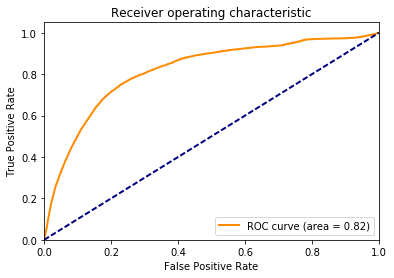

In [57]:
#load results in empty array
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=1, penalty='l1',class_weight='balanced')))


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.8225281   0.83145751  0.82926714  0.83403204  0.83473126]
train time: 1787.908s
test time:  0.160s
accuracy:   0.774
dimensionality: 10541
density: 0.833887
top keywords:
	-0.3472	account xx xx  		0.3305	account xx     

	-0.2574	possible thank 		0.2005	victim identity

	-0.2215	nationstar     		0.1879	fair credit reporting

	-0.2140	company file   		0.1807	home depot     

	-0.2105	nationstar mortgage		0.1534	accounts credit report

	-0.1994	inquires       		0.1201	refused refund xxxx

	-0.1940	bayview        		0.1195	experian       

	-0.1916	tax lien       		0.1116	accounts disputed

	-0.1903	depot          		0.1107	core advisory  

	-0.1893	credit reporting act		0.1081	comerica bank charged

classification report:
             precision    recall  f1-score   support

          0       0.98      0.78      0.87    134272
    

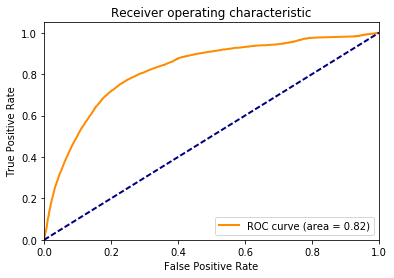

In [56]:
#load results in empty array
#tri-gram 10K features
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.1, penalty='l1',class_weight='balanced')))


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.86551361  0.86482829  0.8644847   0.86347599  0.86448014]
train time: 212.715s
test time:  0.109s
accuracy:   0.764
dimensionality: 6541
density: 0.271824
top keywords:
	-0.0939	nationstar     		0.0562	fee            

	-0.0803	reporting      		0.0562	macy           

	-0.0694	credit         		0.0504	experian       

	-0.0635	ocwen          		0.0327	appraisal      

	-0.0538	debt           		0.0301	closing        

	-0.0520	credit report  		0.0299	fees           

	-0.0446	years          		0.0278	late fees      

	-0.0436	name           		0.0265	refund         

	-0.0426	information    		0.0264	charges        

	-0.0342	inquiry        		0.0208	check cash     

classification report:
             precision    recall  f1-score   support

          0       0.98      0.76      0.86    134385
          1       0.20      0.82      0.

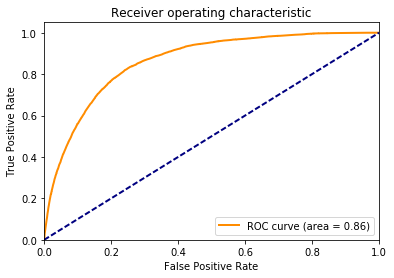

In [43]:
#loZad results in empty array
#tri-gram 10K features
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.001, penalty='l1',class_weight='balanced')))


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.86151331  0.86879592  0.8653556   0.86707275  0.86585251]
train time: 214.644s
test time:  0.113s
accuracy:   0.767
dimensionality: 10541
density: 0.274547
top keywords:
	-0.0902	reporting      		0.0561	fee            

	-0.0796	credit         		0.0559	experian       

	-0.0784	nationstar     		0.0475	macy           

	-0.0674	debt           		0.0326	fees           

	-0.0663	ocwen          		0.0325	appraisal      

	-0.0630	information    		0.0319	closing        

	-0.0562	bb             		0.0301	core advisory  

	-0.0557	years          		0.0242	refund         

	-0.0480	credit report  		0.0229	process        

	-0.0382	please         		0.0186	check cash     

classification report:
             precision    recall  f1-score   support

          0       0.98      0.76      0.86    134272
          1       0.20      0.81      0

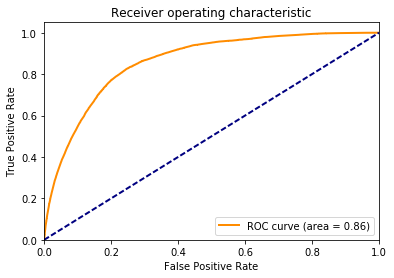

In [60]:
#loZad results in empty array
#tri-gram 10K features
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.001, penalty='l1',class_weight='balanced')))


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.84490695  0.85243978  0.8501906   0.85109098  0.84898602]
train time: 21.301s
test time:  0.091s
accuracy:   0.782
dimensionality: 10541
density: 0.001613
top keywords:
	0.0000	aaa active     		0.0488	fee            

	0.0000	aaa active credit		0.0173	macy           

	0.0000	able           		0.0164	refund         

	0.0000	able access    		0.0136	fees           

	0.0000	able access money		0.0130	charged        

	0.0000	able charge    		0.0054	charges        

	0.0000	able charge overdraft		0.0053	core advisory  

	0.0000	able give credit		0.0052	appraisal      

	0.0000	able refund    		0.0048	closing        

	0.0000	able reverse   		0.0000	zon            

classification report:
             precision    recall  f1-score   support

          0       0.98      0.78      0.87    134272
          1       0.20      0.77      0

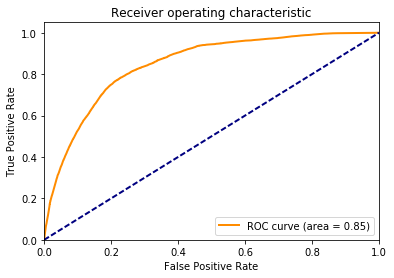

In [61]:
#load results in empty array
#tri-gram 10K features
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.0001, penalty='l1',class_weight='balanced')))


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.85168108  0.85923854  0.85605731  0.85890464  0.85774367]
train time: 983.155s
test time:  0.088s
accuracy:   0.775
dimensionality: 10541
density: 0.681624
top keywords:
	-0.1598	nationstar     		0.1122	experian       

	-0.1422	ocwen          		0.0677	core advisory  

	-0.1244	reporting      		0.0647	transunion     

	-0.1027	card           		0.0582	home depot     

	-0.1018	bb             		0.0565	victim identity

	-0.0929	medical        		0.0519	charges happened

	-0.0827	remove         		0.0501	accounts disputed

	-0.0781	credit report  		0.0434	two three business

	-0.0781	nationstar mortgage		0.0402	macy credit    

	-0.0710	sls            		0.0363	xx xx xxxx     

classification report:
             precision    recall  f1-score   support

          0       0.98      0.77      0.87    134272
          1       0.20      0

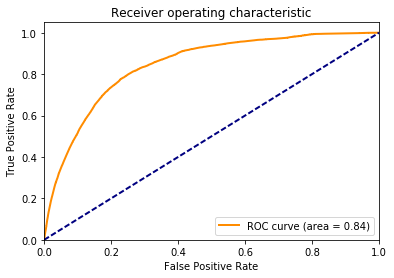

In [62]:
#load results in empty array
#tri-gram 10K features
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.01, penalty='l1',class_weight='balanced')))


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.85372211  0.85418781  0.85327961  0.85617536  0.85559732]
train time: 121.380s
test time:  0.042s
accuracy:   0.754
dimensionality: 4000
density: 0.012500
classification report:
             precision    recall  f1-score   support

          0       0.98      0.75      0.85    134383
          1       0.19      0.82      0.31      9591

avg / total       0.93      0.75      0.81    143974

confusion matrix:
[[100707  33676]
 [  1688   7903]]


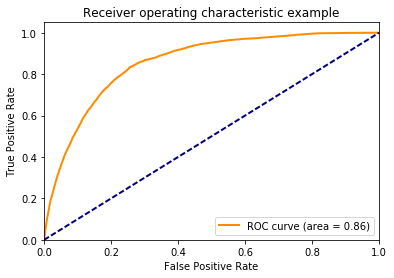

In [138]:
#load results in empty array
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.01, penalty='l1',class_weight='balanced')))


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.86092646  0.86157104  0.86047726  0.86293515  0.86268805]
train time: 624.001s
test time:  0.045s
accuracy:   0.760
dimensionality: 4000
density: 0.053750
classification report:
             precision    recall  f1-score   support

          0       0.98      0.75      0.85    134383
          1       0.19      0.83      0.32      9591

avg / total       0.93      0.76      0.82    143974

confusion matrix:
[[101437  32946]
 [  1625   7966]]


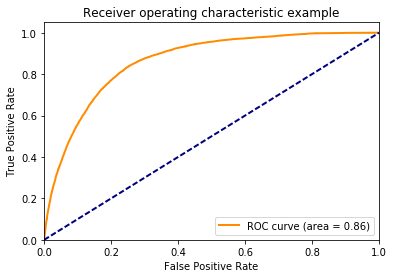

In [139]:
#load results in empty array
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.1, penalty='l1',class_weight='balanced')))


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.86399707  0.86475555  0.8638917   0.86577675  0.8647291 ]
train time: 3220.370s
test time:  0.016s
accuracy:   0.765
dimensionality: 4000
density: 0.222000
top 10 keywords:
	-41.1913	ability apply online		41.8700	abandoned ought underwriter

	-19.8970	ability benefit thats		24.8394	abandoned actively

	-16.0193	abandoned vacant insurance		21.2192	ability lease new

	-13.4911	ability life   		14.4645	abiding texas  

	-13.4671	ability could  		13.9820	abc enormous   

	-12.5622	abilities taking care		13.7659	aadvantage points placed

	-12.4508	ability get car		13.5002	ability simple 

	-11.8594	abd didnt      		13.2643	abide reasonable

	-11.0769	abide terms boa		12.6718	abandoned warehouse attempt

	-10.7172	abiding original		11.4552	ability felony 

classification report:
             precision    recall  f1-score   support

 

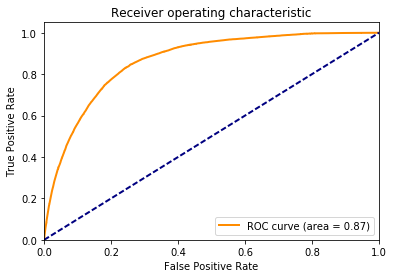

In [174]:
THESE WERE BROKEN- NOT STANDARDIZED
#load results in empty array
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=1, penalty='l1',class_weight='balanced')))


unigram
LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.85622583  0.85889937  0.85137795  0.85697762  0.85619799]
train time: 3349.417s
test time:  0.073s
accuracy:   0.771
dimensionality: 4541
density: 0.956177
top keywords:
	-0.2433	nationstar     		0.1235	experian       

	-0.2338	bayview        		0.0930	macy           

	-0.2240	consultants    		0.0851	wells          

	-0.2175	sls            		0.0821	transunion     

	-0.2021	remov          		0.0718	fee            

	-0.1814	ocwen          		0.0560	advisory       

	-0.1790	nelnet         		0.0524	fees           

	-0.1747	inquires       		0.0434	thexxxx        

	-0.1564	roundpoint     		0.0432	america        

	-0.1548	scottrade      		0.0403	cach           

classification report:
             precision    recall  f1-score   support

          0       0.98      0.77      0.86    134253
          1       0.20      0.8

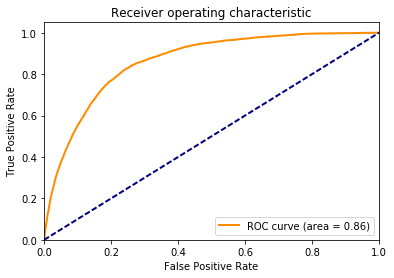

In [83]:
#load results in empty array

print('unigram')
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.1, penalty='l1',class_weight='balanced')))


unigram
LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.85385396  0.85680854  0.84924605  0.85466003  0.85396408]
train time: 1108.847s
test time:  0.079s
accuracy:   0.771
dimensionality: 4541
density: 0.982383
top keywords:
	-0.5342	bayview        		0.1247	experian       

	-0.5341	consultants    		0.0934	macy           

	-0.3875	scottrade      		0.0909	wells          

	-0.3614	remov          		0.0833	transunion     

	-0.3299	nelnet         		0.0722	fee            

	-0.3083	selene         		0.0573	advisory       

	-0.3046	transworld     		0.0565	compliments    

	-0.3025	sls            		0.0557	confounding    

	-0.2940	unverifiable   		0.0526	fees           

	-0.2883	diversified    		0.0465	transactionsxxxx

classification report:
             precision    recall  f1-score   support

          0       0.98      0.77      0.86    134253
          1       0.20      0.

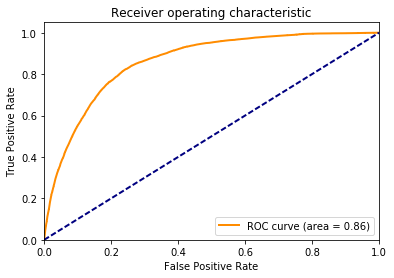

In [84]:
#load results in empty array
print('unigram')
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=1, penalty='l1',class_weight='balanced')))


unigram
LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.85289604  0.85591691  0.84865041  0.85338049  0.85297674]
train time: 842.915s
test time:  0.073s
accuracy:   0.771
dimensionality: 4541
density: 0.987007
top keywords:
	-0.8090	consultants    		0.1247	experian       

	-0.7095	bayview        		0.1191	confounding    

	-0.6799	unverifiable   		0.0935	macy           

	-0.6285	scottrade      		0.0914	wells          

	-0.6215	selene         		0.0834	transunion     

	-0.5751	nelnet         		0.0815	compliments    

	-0.5564	convergent     		0.0722	fee            

	-0.5349	remov          		0.0647	thrones        

	-0.5211	bmw            		0.0646	transactionsxxxx

	-0.5162	medicaid       		0.0589	overhauling    

classification report:
             precision    recall  f1-score   support

          0       0.98      0.77      0.86    134253
          1       0.20      0.8

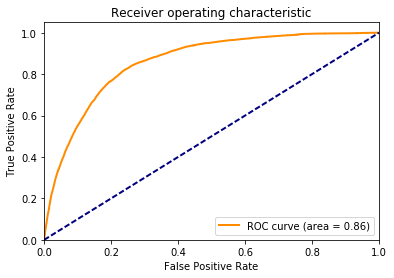

In [85]:
#load results in empty array
print('unigram')
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=10, penalty='l1',class_weight='balanced')))


unigram
LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.85047187  0.85129503  0.84627225  0.8527467   0.85192039]
train time: 1843.768s
test time:  0.088s
accuracy:   0.776
dimensionality: 10541
density: 0.772507
top keywords:
	-0.2602	ocwen          		0.1164	experian       

	-0.2035	nationstar     		0.0938	macy           

	-0.1461	reporting      		0.0720	fee            

	-0.1346	report         		0.0558	fees           

	-0.1006	bb             		0.0508	transunion     

	-0.0918	inquiry        		0.0490	advisory       

	-0.0906	sls            		0.0418	america        

	-0.0860	equifax        		0.0409	appraisal      

	-0.0816	nelnet         		0.0404	cach           

	-0.0766	delete         		0.0395	statement      

classification report:
             precision    recall  f1-score   support

          0       0.98      0.78      0.87    134253
          1       0.20      0.

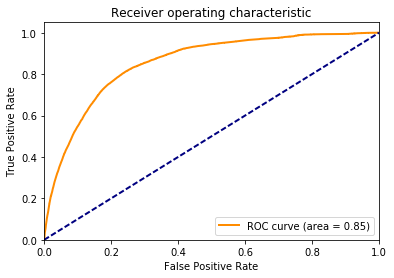

In [95]:
#load results in empty array
print('unigram')
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.01, penalty='l1',class_weight='balanced')))


unigram
LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.82868151  0.82795302  0.82232722  0.82904811  0.82748771]
train time: 2883.835s
test time:  0.086s
accuracy:   0.777
dimensionality: 10541
density: 0.925149
top keywords:
	-0.4546	ocwen          		0.1225	experian       

	-0.3590	sls            		0.1063	macy           

	-0.2972	doe            		0.1039	solvency       

	-0.2866	nationstar     		0.0814	fee            

	-0.2768	bayview        		0.0735	advisory       

	-0.2677	nelnet         		0.0729	wells          

	-0.2503	xxxxaccount    		0.0637	fees           

	-0.2069	falsified      		0.0590	green          

	-0.2049	cbe            		0.0566	transunion     

	-0.1876	upside         		0.0526	insf           

classification report:
             precision    recall  f1-score   support

          0       0.98      0.78      0.87    134253
          1       0.20      0.

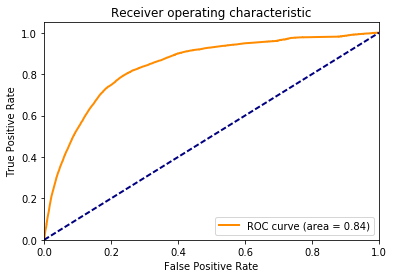

In [96]:
#load results in empty array
print('unigram')
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=.1, penalty='l1',class_weight='balanced')))


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.86399737  0.86475692  0.86389261  0.86577924  0.86472823]
train time: 3566.912s
test time:  0.018s
accuracy:   0.765
dimensionality: 4000
density: 0.221500
classification report:
             precision    recall  f1-score   support

          0       0.98      0.76      0.86    134383
          1       0.20      0.83      0.32      9591

avg / total       0.93      0.76      0.82    143974

confusion matrix:
[[102191  32192]
 [  1661   7930]]


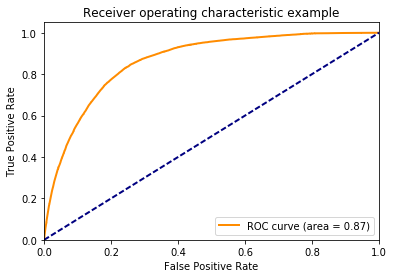

In [140]:
#load results in empty array
#best result
#unigram 4k features
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=1, penalty='l1',class_weight='balanced')))


LogReg
________________________________________________________________________________
Training: 
LogReg
stratified 5-fold cross validation roc_auc score:  [ 0.86282643  0.86363928  0.86237455  0.8643444   0.86245494]
train time: 8792.375s
test time:  0.018s
accuracy:   0.770
dimensionality: 4000
density: 0.732250
classification report:
             precision    recall  f1-score   support

          0       0.98      0.77      0.86    134383
          1       0.20      0.81      0.32      9591

avg / total       0.93      0.77      0.83    143974

confusion matrix:
[[103098  31285]
 [  1833   7758]]


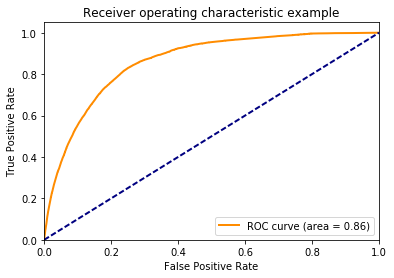

In [141]:

#load results in empty array
results=[]

clf_type='LogReg'              
print(clf_type)               
results.append(benchmark(linear_model.LogisticRegression(C=10, penalty='l1',class_weight='balanced')))


tri-gram, 5k features
Naive Bayes
________________________________________________________________________________
Training: 
Naive Bayes
stratified 5-fold cross validation roc_auc score:  [ 0.77051298  0.76488164  0.7657872   0.76424707  0.76895757]
train time: 2.189s
test time:  0.091s
accuracy:   0.919
dimensionality: 6541
density: 1.000000
top keywords:
	-20.9345	delete information		-6.4791	fee            

	-20.9345	delete information verified		-6.5248	card           

	-20.9345	fcra required  		-6.5768	charged        

	-20.9345	portfolio recovery		-6.5863	bank           

	-20.9345	possible thank 		-6.5942	fees           

	-20.9345	promptly delete		-6.6043	account        

	-20.9345	promptly delete information		-6.7261	would          

	-20.9345	required promptly		-6.7263	charge         

	-20.9345	required promptly delete		-6.7626	charges        

	-20.9345	verify accounts		-6.8584	told           

classification report:
             precision    recall  f1-score   support

  

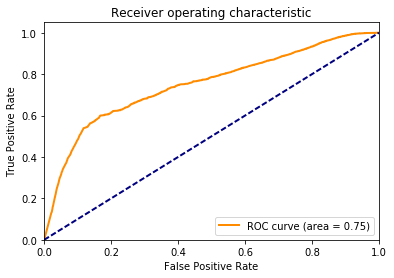

In [42]:
#load results in empty array
print('tri-gram, 5k features')

results=[]

clf_type='Naive Bayes'
print(clf_type)
results.append(benchmark(MultinomialNB(alpha=.01)))

In [ ]:
#test
#load results in empty array
print('tri-gram, 1ok features')

results=[]

clf_type='Naive Bayes'
print(clf_type)
results.append(benchmark(MultinomialNB(alpha=.01)))

unigram
Naive Bayes
________________________________________________________________________________
Training: 
Naive Bayes
stratified 5-fold cross validation roc_auc score:  [ 0.75359062  0.75846994  0.75537128  0.7543741   0.7597135 ]
train time: 2.367s
test time:  0.101s
accuracy:   0.923
dimensionality: 10541
density: 1.000000
top keywords:
	-21.2188	accounts section fcra		-6.7643	fee            

	-21.2188	bayview        		-6.8188	card           

	-21.2188	company file used		-6.8767	bank           

	-21.2188	delete information		-6.8848	charged        

	-21.2188	delete information verified		-6.8873	fees           

	-21.2188	disputed gone  		-6.9105	account        

	-21.2188	disputed please		-7.0201	charge         

	-21.2188	disputed please resolve		-7.0308	would          

	-21.2188	documents company file		-7.0738	charges        

	-21.2188	fcra required  		-7.1435	called         

classification report:
             precision    recall  f1-score   support

          0       

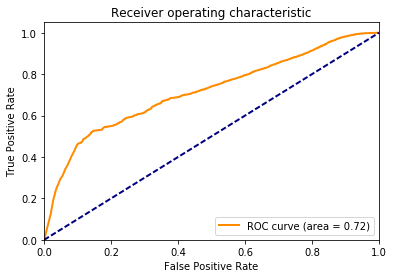

In [64]:
#test
#load results in empty array
print('unigram')

results=[]

clf_type='Naive Bayes'
print(clf_type)
results.append(benchmark(MultinomialNB(alpha=.01)))

unigram
Naive Bayes
________________________________________________________________________________
Training: 
Naive Bayes
stratified 5-fold cross validation roc_auc score:  [ 0.75359062  0.75846994  0.75537128  0.7543741   0.7597135 ]
train time: 2.383s
test time:  0.098s
accuracy:   0.923
dimensionality: 10541
density: 1.000000
top keywords:
	-21.2188	accounts section fcra		-6.7643	fee            

	-21.2188	bayview        		-6.8188	card           

	-21.2188	company file used		-6.8767	bank           

	-21.2188	delete information		-6.8848	charged        

	-21.2188	delete information verified		-6.8873	fees           

	-21.2188	disputed gone  		-6.9105	account        

	-21.2188	disputed please		-7.0201	charge         

	-21.2188	disputed please resolve		-7.0308	would          

	-21.2188	documents company file		-7.0738	charges        

	-21.2188	fcra required  		-7.1435	called         

classification report:
             precision    recall  f1-score   support

          0       

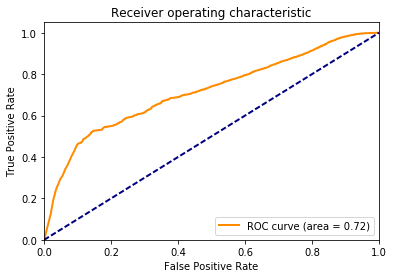

In [ ]:
#test
#load results in empty array
print('unigram')

results=[]

clf_type='Naive Bayes'
print(clf_type)
results.append(benchmark(MultinomialNB(alpha=.01)))

In [ ]:
results=[]

print('trigram')
clf_type='SVM'
print(clf_type)        
results.append(benchmark(svm.SVC(kernel='linear',class_weight='balanced', C=10**(-2))))


unigram
SVM
________________________________________________________________________________
Training: 
SVM


SVM
________________________________________________________________________________
Training: 
SVM
stratified 5-fold cross validation roc_auc score:  [ 0.83706839  0.83454243  0.83787187  0.83887992  0.83725329]
train time: 104538.951s
test time:  4042.016s
accuracy:   0.753
dimensionality: 3000
density: 0.902667
classification report:
             precision    recall  f1-score   support

          0       0.98      0.75      0.85    134321
          1       0.19      0.83      0.31      9653

avg / total       0.93      0.75      0.81    143974

confusion matrix:
[[100357  33964]
 [  1643   8010]]


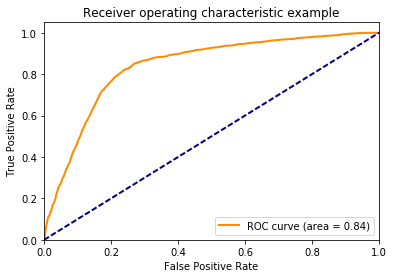

In [229]:
results=[]

clf_type='SVM'
print(clf_type)        
results.append(benchmark(svm.SVC(kernel='linear',class_weight='balanced', C=10**(-2))))


SVM
________________________________________________________________________________
Training: 
SVM
train time: 52906.346s
test time:  4553.887s
accuracy:   0.758
dimensionality: 4000
density: 0.883500
classification report:
             precision    recall  f1-score   support

          0       0.98      0.75      0.85    134383
          1       0.19      0.82      0.31      9591

avg / total       0.93      0.76      0.82    143974

confusion matrix:
[[101164  33219]
 [  1686   7905]]


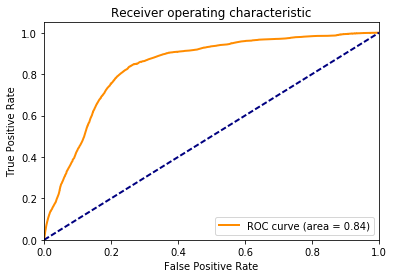

In [ ]:
results=[]

clf_type='SVM'
print(clf_type)        
results.append(benchmark(svm.SVC(kernel='linear',class_weight='balanced', C=10**(0))))

In [ ]:
results=[]

clf_type='SVM'
print(clf_type)  
print('tri-gram')  
results.append(benchmark(svm.SVC(kernel='linear',class_weight='balanced', C=10**(1))))

SVM
tri-gram
________________________________________________________________________________
Training: 


SVM
________________________________________________________________________________
Training: 
SVM
stratified 5-fold cross validation roc_auc score:  [ 0.67964342  0.74543805  0.63264535  0.64059314  0.62548318]
train time: 28046.656s
test time:  2355.294s
accuracy:   0.933
dimensionality: 3000
density: 1.000000
classification report:
             precision    recall  f1-score   support

          0       0.94      1.00      0.97    134321
          1       0.52      0.04      0.07      9653

avg / total       0.91      0.93      0.91    143974

confusion matrix:
[[133987    334]
 [  9291    362]]


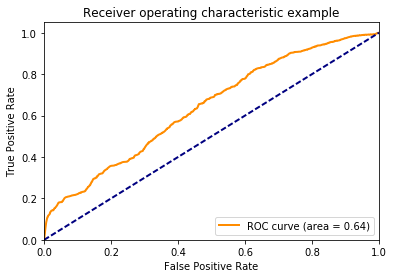


SVM
________________________________________________________________________________
Training: 
SVM


KeyboardInterrupt: 

In [227]:
results=[]

clf_type='SVM'
print(clf_type)        
results.append(benchmark(svm.SVC(kernel='linear',class_weight='balanced', C=10**(-2))))

clf_type='SVM'
print(clf_type)        
results.append(benchmark(svm.SVC(kernel='linear',class_weight='balanced', C=10**(-1))))

clf_type='SVM'
print(clf_type)        
results.append(benchmark(svm.SVC(kernel='linear',class_weight='balanced', C=10**(0))))

clf_type='SVM'
print(clf_type)        
results.append(benchmark(svm.SVC(kernel='linear',class_weight='balanced', C=10**(1))))
      
